# import library

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from collections import Counter
import numpy as np
import plotnine as pn
pn.options.figure_size = (30, 10)

In [3]:
import os
from sklearn.metrics import r2_score, mean_squared_error
import glob

In [4]:
!ls ../data

book_test.parquet     test.csv              train.csv
book_train.parquet    trade_test.parquet
sample_submission.csv trade_train.parquet


# data

## train & test 데이터

In [4]:
trainD = pd.read_csv('../data/train.csv')
trainD

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


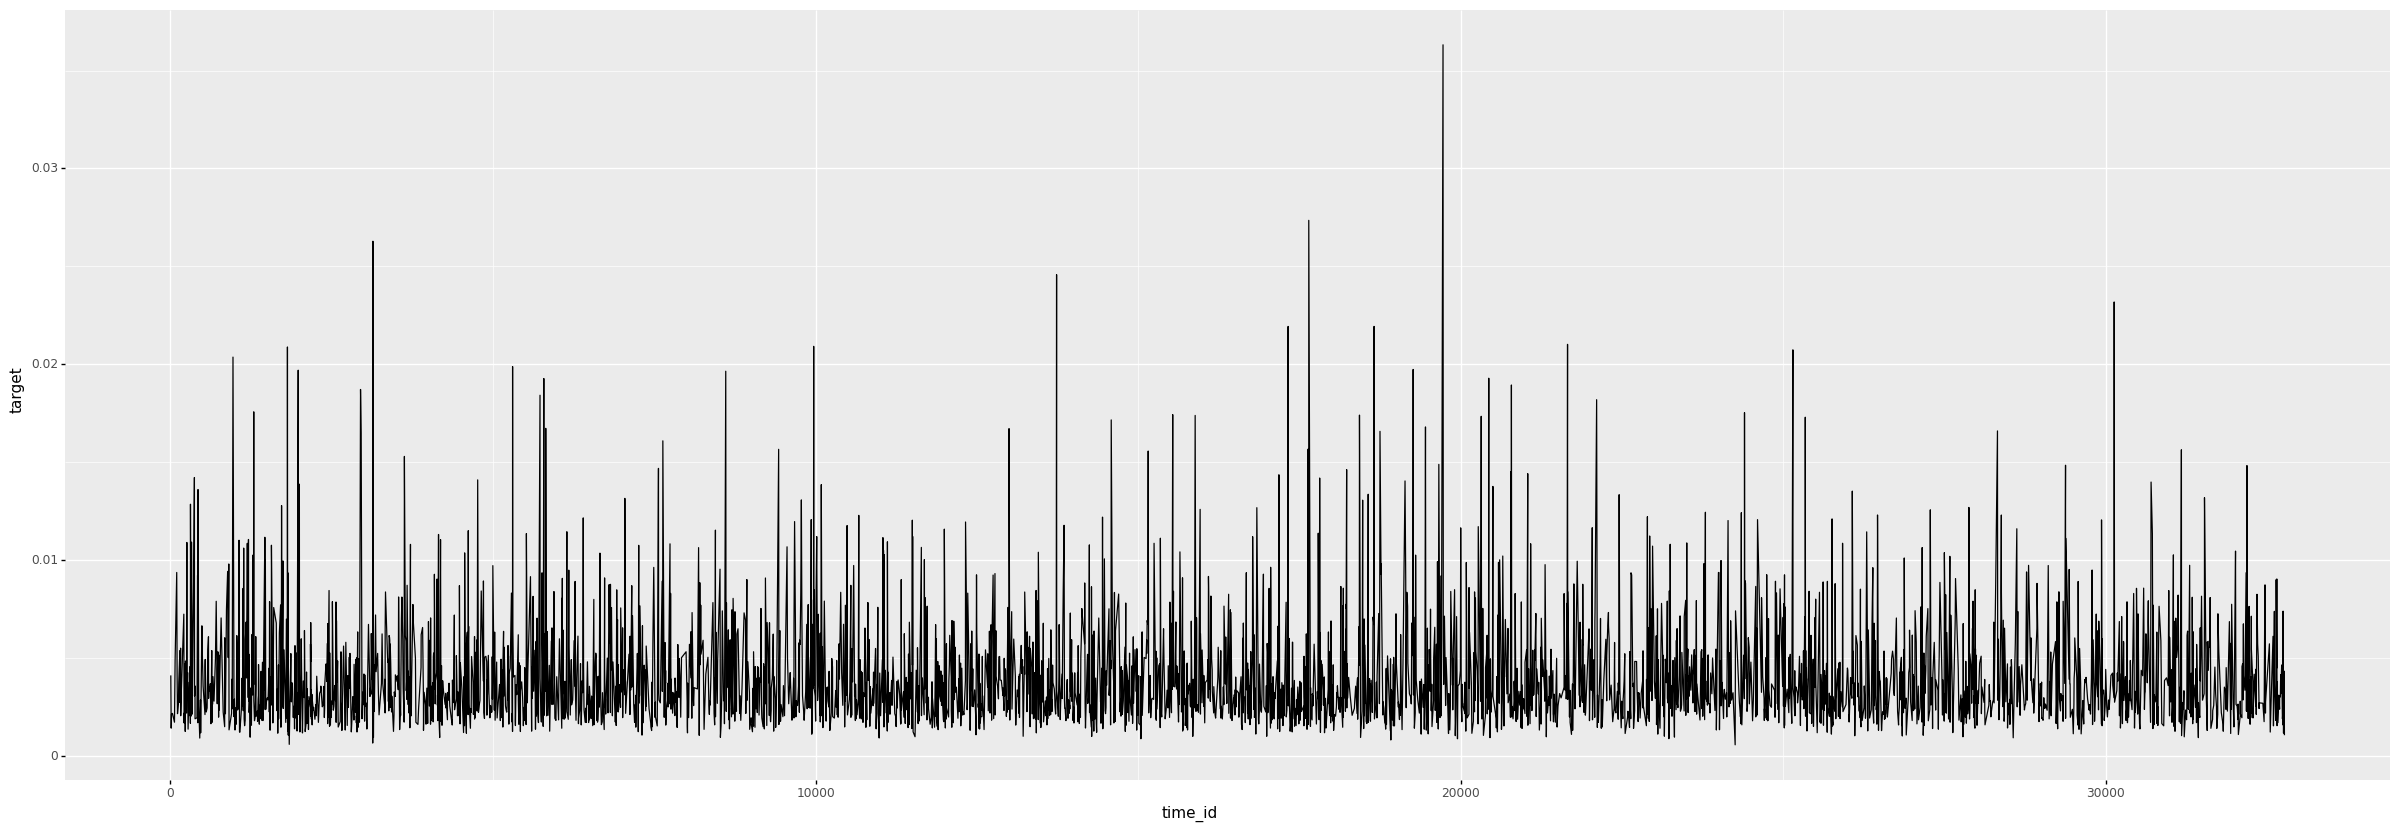

<ggplot: (8762605030429)>

In [5]:
pn.ggplot(pn.aes(x=trainD[trainD['stock_id']==0]['time_id'], y=trainD[trainD['stock_id']==0]['target'])) + pn.geom_line()

In [6]:
testD = pd.read_csv('../data/test.csv')
testD.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


-> stock-id, time-id 별  target(realized-volatility) 값 예측

## book 데이터 (파티션 : stock_id)

In [7]:
# 일단, 파티션 하나만
bookD = pd.read_parquet('../data/book_train.parquet/stock_id=0')
bookD.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


## trade 데이터 (파티션 : stock_id)

In [8]:
# 일단, 파티션 하나만
tradeD = pd.read_parquet('../data/trade_train.parquet/stock_id=0')
tradeD.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


# target 변수 : realized volatility

## wap 계산 함수

In [9]:
def get_wap(
    df: pd.DataFrame,
    ask_size_col: str, 
    ask_price_col: str, 
    bid_size_col: str, 
    bid_price_col: str,
    apply_log: bool = True
) -> pd.Series:
    
    wap = (
        (df[ask_price_col] * df[bid_size_col]) + (df[bid_price_col] * df[ask_size_col])
    ) / (df[ask_size_col] + df[bid_size_col])

    if apply_log:
        wap = np.log(wap)
    
    return wap.diff()

In [11]:
bookD['wap'] = get_wap(
    df=bookD,
    ask_size_col='ask_size1', ask_price_col='ask_price1',
    bid_size_col='bid_size1', bid_price_col='bid_price1',
)

## realized volatility 계산 함수

In [12]:
def get_realized_volatility(wap: pd.Series) -> float:
    return np.sqrt(np.sum(wap**2))

In [13]:
# time_id 별로 realized_volatility 계산 후, trainD와 값 비교
stock_id0 = bookD.groupby('time_id', as_index=False)['wap'].agg(get_realized_volatility).rename(columns={'wap':'target'})
cmpr = pd.merge(trainD[trainD['stock_id']==0].reset_index(drop=True).drop('stock_id', axis=1), stock_id0, on='time_id')
cmpr

,time_id,target_x,target_y
0,5,0.004136,0.004499
1,11,0.001445,0.003966
2,16,0.002168,0.002451
3,31,0.002195,0.003742
4,62,0.001747,0.003210
...,...,...,...
3825,32751,0.002611,0.002660
3826,32753,0.001190,0.004234
3827,32758,0.004264,0.003368
3828,32763,0.004352,0.003280


## RMSPE 계산 함수

In [14]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [15]:
R2 = round(r2_score(y_true = cmpr['target_x'], y_pred = cmpr['target_y']), 3)
RMSPE = round(rmspe(y_true = cmpr['target_x'], y_pred = cmpr['target_y']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: -1.196, RMSPE: 1.674


## shift

In [ ]:
bookD['wap'] = get_wap(
    df=bookD,
    ask_size_col='ask_size2', ask_price_col='ask_price2',
    bid_size_col='bid_size2', bid_price_col='bid_price2',
)

In [ ]:
# time_id 별로 realized_volatility 계산 후, trainD와 값 비교
stock_id0 = bookD.groupby('time_id', as_index=False)['wap'].agg(get_realized_volatility).rename(columns={'wap':'target'})
cmpr = pd.merge(trainD[trainD['stock_id']==0].reset_index(drop=True).drop('stock_id', axis=1), stock_id0, on='time_id')
cmpr

In [ ]:
R2 = round(r2_score(y_true = cmpr['target_x'], y_pred = cmpr['target_y']), 3)
RMSPE = round(rmspe(y_true = cmpr['target_x'], y_pred = cmpr['target_y']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

In [ ]:
r2_score(y_true = cmpr['target_x'], y_pred = cmpr['target_y'])

In [ ]:
mj = pd.DataFrame({'a':[3, -0.5, 2, 7],'b':[2.5, 0.0, 2, 8]})

In [ ]:
r2_score(y_true = mj['a'], y_pred=mj['b'])

In [ ]:
cmpr